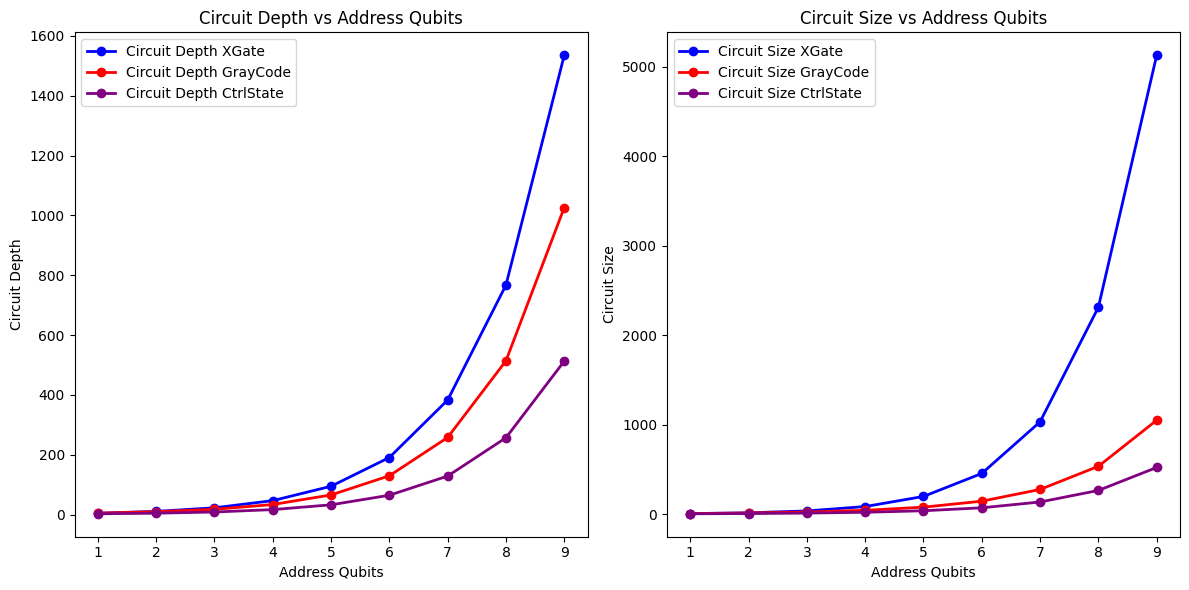

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes

# Funzione per calcolare la profondità e la dimensione del circuito per diverse dimensioni del dataset
def calculate_circuit_metrics_XGate(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
    
        for j, bit in enumerate(binary_index):
            if bit == '0':
                circuit.append(XGate(), [qaddr[j]])
    
        circuit.barrier()


    return circuit.depth(), circuit.size()

def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
        
        circuit.barrier()

    return circuit.depth(), circuit.size()

def calculate_circuit_metrics(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    
    qaddr = QuantumRegister(n, 'addr')
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    i=0
    for el in memory_values:
        theta=calculate_theta(el, max_value)
        binary_index = bin(i)[2:].zfill(n)
        CRYGate = RYGate(theta).control(n, ctrl_state=binary_index)
        circuit.append(CRYGate, qaddr[:] + [qdata[0]])
        i+=1
        circuit.barrier()


    return circuit.depth(), circuit.size()

# Generare dataset di diverse dimensioni (potenze di 2)
dataset_sizes = [i for i in range(1, 10)]
depths_XGate = []
sizes_XGate = []
depths_GrayCode = []
sizes_GrayCode = []
depths_ctrlstate = []
sizes_ctrlstate = []

for size in dataset_sizes:
    memory_values = list(range(1, (2**size) + 1))
    depth, size = calculate_circuit_metrics_XGate(memory_values)
    depths_XGate.append(depth)
    sizes_XGate.append(size)
    depth, size = calculate_circuit_metrics_GrayCode(memory_values)
    depths_GrayCode.append(depth)
    sizes_GrayCode.append(size)
    depth, size = calculate_circuit_metrics(memory_values)
    depths_ctrlstate.append(depth)
    sizes_ctrlstate.append(size)


# Plotting
plt.figure(figsize=(12, 6))

# Tracciare Circuit Depth
plt.subplot(1, 2, 1)
plt.plot(dataset_sizes, depths_XGate, marker='o', color='blue', linewidth=2, label='Circuit Depth XGate')
plt.plot(dataset_sizes, depths_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Depth GrayCode')
plt.plot(dataset_sizes, depths_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Depth CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Depth')
plt.legend()
plt.title('Circuit Depth vs Address Qubits')

# Tracciare Circuit Size
plt.subplot(1, 2, 2)
plt.plot(dataset_sizes, sizes_XGate, marker='o', color='blue', linewidth=2, label='Circuit Size XGate')
plt.plot(dataset_sizes, sizes_GrayCode, marker='o', color='red', linewidth=2, label='Circuit Size GrayCode')
plt.plot(dataset_sizes, sizes_ctrlstate, marker='o', color='purple', linewidth=2, label='Circuit Size CtrlState')
plt.xlabel('Address Qubits')
plt.ylabel('Circuit Size')
plt.legend()
plt.title('Circuit Size vs Address Qubits')

plt.tight_layout()
plt.show()





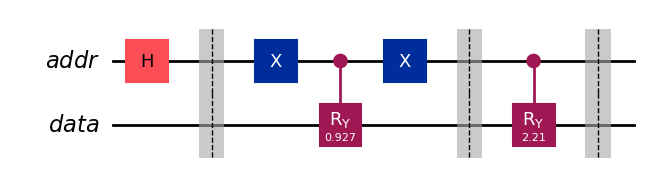

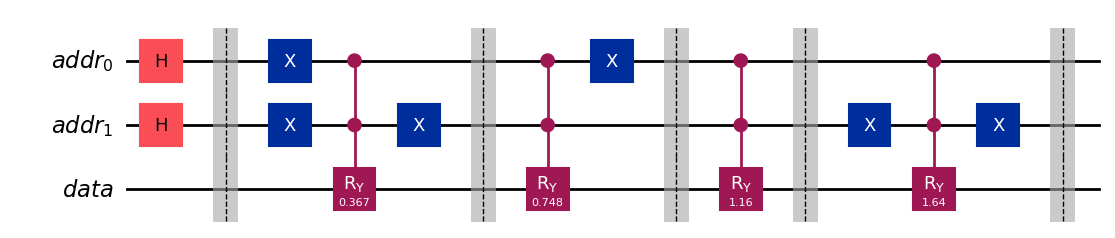

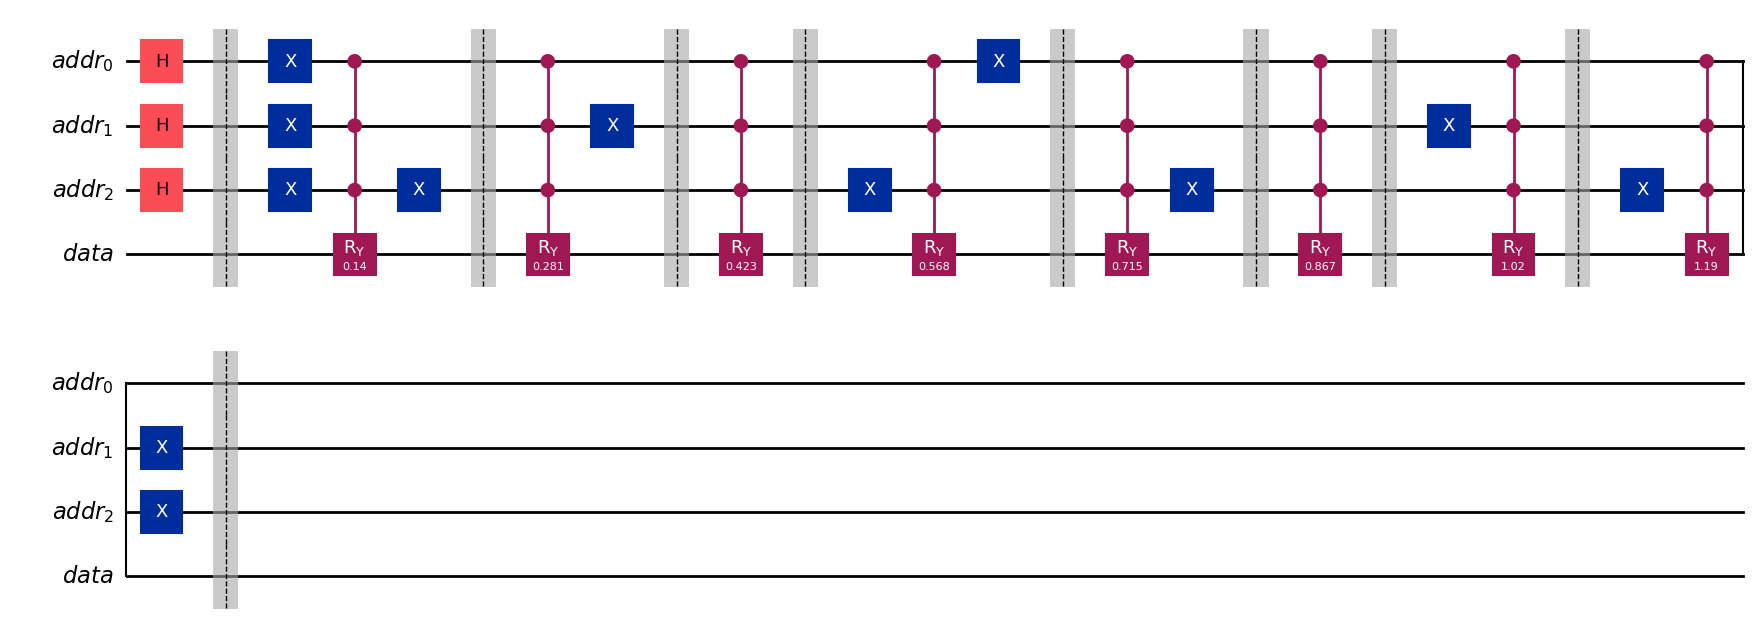

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import HGate, CXGate, RYGate, XGate
from numpy import arcsin, sqrt, pi
import math
from matplotlib import pyplot as plt
from IPython.display import display
# Funzione per calcolare il valore di θ
def calculate_theta(value, max_value):
    X_N = value / sqrt(max_value)
    return 2 * arcsin(X_N)


# Funzione per generare il codice Gray
def gray_code(n):
    """Generate n-bit Gray code iteratively."""
    if n == 0:
        return ['0']
    if n == 1:
        return ['0', '1']
    
    gray_codes = ['0', '1']
    for i in range(2, n + 1):
        # Create the next sequence by reflecting the current sequence
        reflected = ['1' + code for code in reversed(gray_codes)]
        gray_codes = ['0' + code for code in gray_codes] + reflected
    
    return gray_codes


def calculate_circuit_metrics_GrayCode(memory_values):
    max_value = sum([x**2 for x in memory_values])
    thetas = [calculate_theta(value, max_value) for value in memory_values]
    N = len(memory_values)
    n = int(math.log2(N))
    countXGate = 0

    qaddr = QuantumRegister(n, 'addr')
    previous_bit = [1] * n
    qdata = QuantumRegister(1, 'data')
    circuit = QuantumCircuit(qaddr, qdata)
    
    for qa in qaddr:
        circuit.append(HGate(), [qa])
    circuit.barrier()
    
    gray_codes = gray_code(n)
    binary_index = list(enumerate(gray_codes[0]))
    
    for i, el in enumerate(memory_values):
        theta = calculate_theta(el, max_value)
        for j, bit in binary_index:
            if bit == '0' and previous_bit[j] == 1:
                circuit.append(XGate(), [qaddr[j]])
                countXGate+=1
            previous_bit[j] = int(bit)
        
        CRYGate = RYGate(theta).control(n)
        circuit.append(CRYGate, qaddr[:n] + [qdata[0]])
        
        if i < N - 1:
            binary_index = list(enumerate(gray_codes[i + 1]))
            for j, next_bit in binary_index:
                if next_bit == '1' and previous_bit[j] == 0:
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        else:
            for j, bit in binary_index:
                if bit == '0':
                    circuit.append(XGate(), [qaddr[j]])
                    countXGate+=1
        
        circuit.barrier()

    # Draw the circuit and display the number of X gates
    display(circuit.draw(output='mpl'))


dataset_size = {i for i in range(1, 4)}

for size in dataset_size:
    memory_values = [i for i in range(1, (2**size) + 1)]

    calculate_circuit_metrics_GrayCode(memory_values)


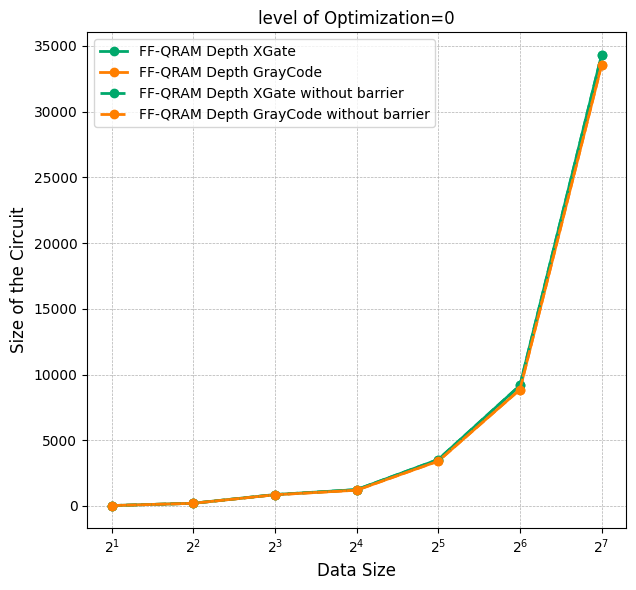

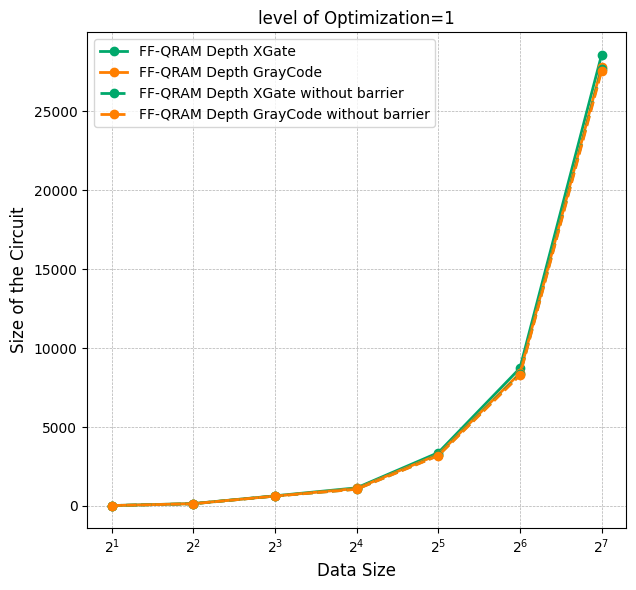

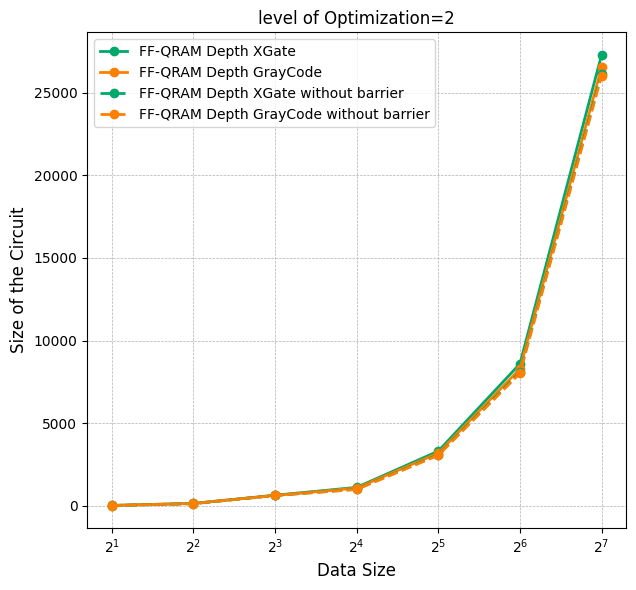

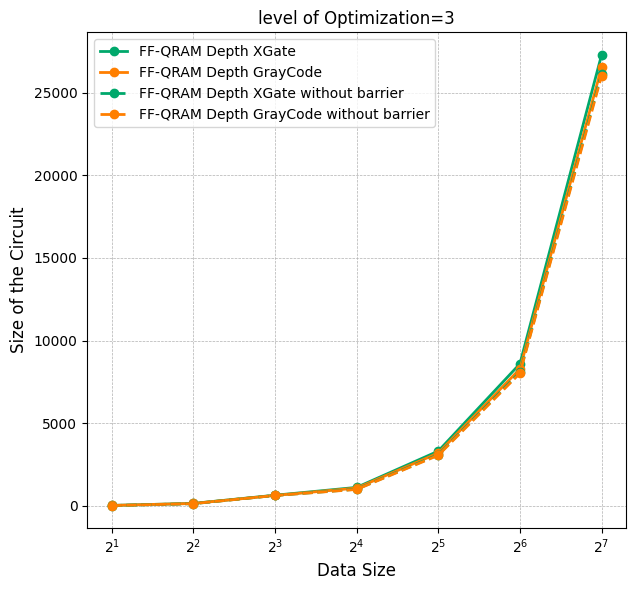

In [6]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1, 8)
datasize = [2**i for i in size]



optimization_levels = range(4)

for opt_level in optimization_levels:
    classic_opt_size = []
    gray_opt_size = []
    classic_opt_size_b = []
    gray_opt_size_b = []

    for el in size:
        _, _, _, classic_opt = ffqram_metrics_classic(2**el, opt_lvl=opt_level)
        _, _, _, gray_opt = ffqram_metrics_graycode(2**el, opt_lvl=opt_level)
        _, _, _, classic_opt_b = ffqram_metrics_classic(2**el, opt_lvl=opt_level, barrier=False)
        _, _, _, gray_opt_b = ffqram_metrics_graycode(2**el, opt_lvl=opt_level, barrier=False)



        classic_opt_size.append(classic_opt)
        gray_opt_size.append(gray_opt)
        classic_opt_size_b.append(classic_opt_b)
        gray_opt_size_b.append(gray_opt_b)

    plt.figure(figsize=(12, 6))

    # Tracciare Circuit Depth
    plt.subplot(1, 2, 1)
    plt.plot(datasize, classic_opt_size, marker='o', color='#00A86B', linewidth=2, label='FF-QRAM Depth XGate')  # Verde
    plt.plot(datasize, gray_opt_size, marker='o', color='#FF7F00', linewidth=2, label='FF-QRAM Depth GrayCode')  # Arancione    
    plt.plot(datasize, classic_opt_size_b, marker='o', color='#00A86B', linewidth=2, linestyle='--', label='FF-QRAM Depth XGate without barrier')  # Verde
    plt.plot(datasize, gray_opt_size_b, marker='o', color='#FF7F00', linewidth=2, linestyle='--', label='FF-QRAM Depth GrayCode without barrier')
    plt.xlabel('Data Size', fontsize=12)
    plt.ylabel('Size of the Circuit', fontsize=12)
    plt.legend()
    plt.title(f'level of Optimization={opt_level}', fontsize=12)
        
    # Miglioramenti estetici
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xscale('log', base=2)
    plt.tight_layout()

    plt.show()


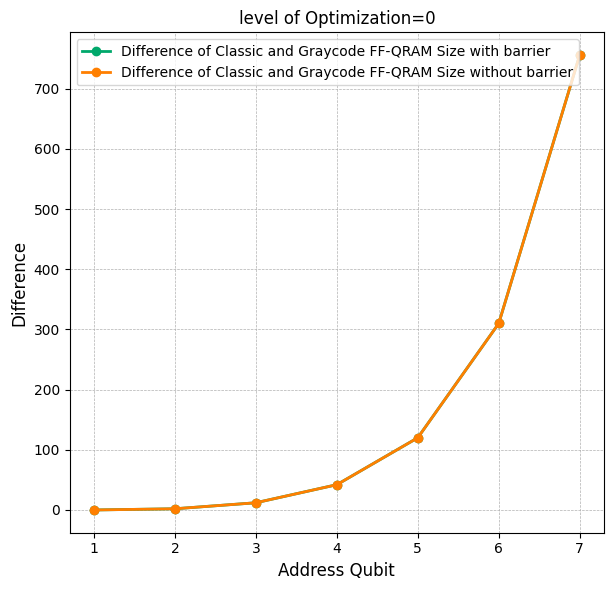

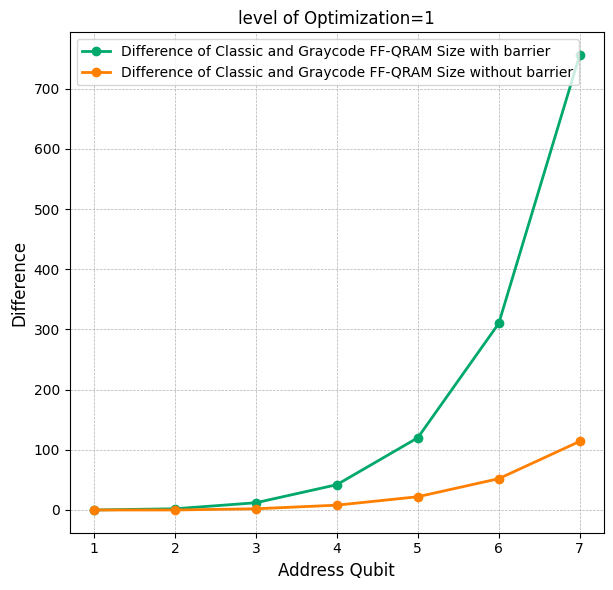

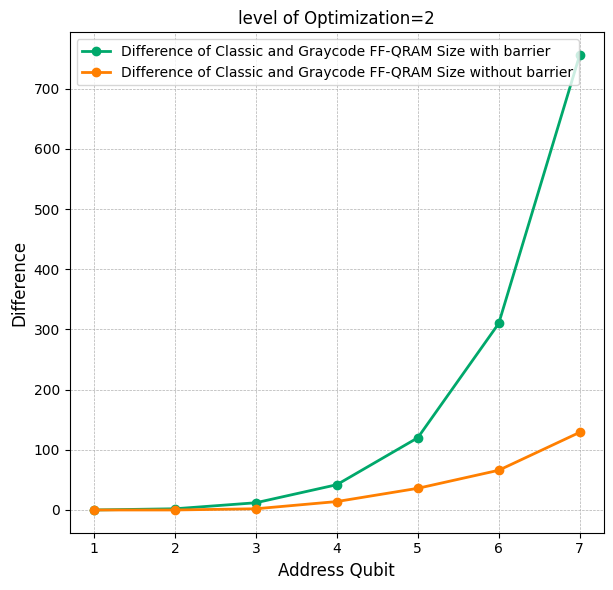

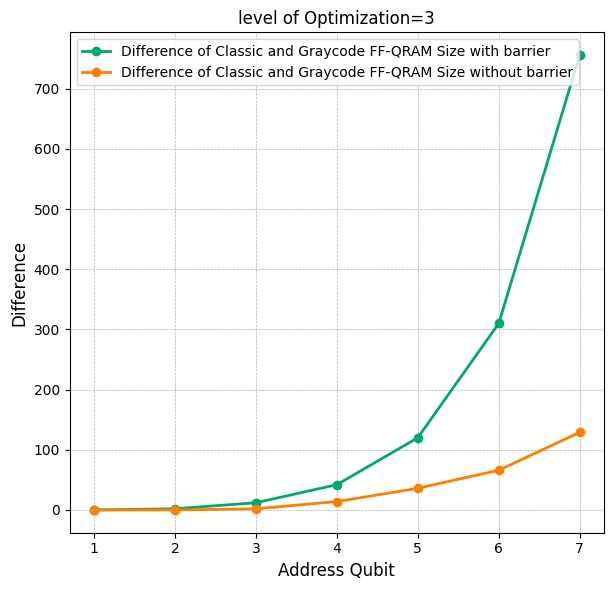

In [7]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1, 8)



optimization_levels = range(4)

for opt_level in optimization_levels:
    difference_size = []
    differnce_size_b = []

    for el in size:
        _, _, _, classic_opt = ffqram_metrics_classic(2**el, opt_lvl=opt_level)
        _, _, _, gray_opt = ffqram_metrics_graycode(2**el, opt_lvl=opt_level)
        _, _, _, classic_opt_b = ffqram_metrics_classic(2**el, opt_lvl=opt_level, barrier=False)
        _, _, _, gray_opt_b = ffqram_metrics_graycode(2**el, opt_lvl=opt_level, barrier=False)



        difference_size.append(classic_opt-gray_opt)
        differnce_size_b.append(classic_opt_b-gray_opt_b)
    plt.figure(figsize=(12, 6))

    # Tracciare Circuit Depth
    plt.subplot(1, 2, 1)
    plt.plot(size, difference_size, marker='o', color='#00A86B', linewidth=2, label='Difference of Classic and Graycode FF-QRAM Size with barrier')  # Verde
    plt.plot(size, differnce_size_b, marker='o', color='#FF7F00', linewidth=2, label='Difference of Classic and Graycode FF-QRAM Size without barrier')  # Arancione
    plt.xlabel('Address Qubit', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.legend()
    plt.title(f'level of Optimization={opt_level}', fontsize=12)
        
    # Miglioramenti estetici
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

In [ ]:
from lib.circuit_metrics import ffqram_metrics_graycode, ffqram_metrics_classic
from matplotlib import pyplot as plt

size = range(1, 8)



optimization_levels = range(4)
    

for el in size:
    _, _, classic, _ = ffqram_metrics_classic(2**el, opt_lvl=opt_level)
    _, _, gray, _= ffqram_metrics_graycode(2**el, opt_lvl=opt_level
    
    classic_size.append(classic)
    gray_size.append(gray)


plt.figure(figsize=(12, 6))
